In [1]:
# 拿到所有的名词和所有的词，选择重要名词
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from paddlenlp.transformers import BertTokenizer, BertModel
import paddle
import matplotlib.pyplot as plt
from matplotlib.myconfig import Config
config=Config()
paddle.set_device('gpu')

all_n=[]
all=[]
all_n_vec=[]
all_vec=[]
with open(r'D:\python_common\代码_感知质量大论文\公开数据处理\感知质量数据集\4000条评论_名词_去重.tsv','r',encoding='utf-8') as f:
    for line in f.readlines():
        all_n.append(line.strip())
with open(r'D:\python_common\代码_感知质量大论文\公开数据处理\感知质量数据集\预处理结果_4000条.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        all.append(line.strip())
class Mybert:
    def __init__(self):
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')
    def get(self,text):
        tokenized_text = self.tokenizer.tokenize(text)
        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        tokens_tensor = paddle.to_tensor([indexed_tokens])
        self.bert.eval()
        with paddle.no_grad():
            # 放到gpu运算
            outputs = self.bert(tokens_tensor.cuda(),output_hidden_states=True)
        return paddle.mean(outputs[2][0],axis=1).numpy().tolist()[0]
mybert=Mybert()

def rbf_attention(vec, memory, gamma):
    z = rbf_kernel(vec, memory, gamma)
    s = z.sum()
    if s == 0:
        return np.ones((1, len(vec))) / len(vec)
    return (z.sum(1) / s)[None, :]
all_n_vec=np.array([mybert.get(each) for each in all_n]).astype(np.float32)
all_vec=np.array([mybert.get(each) for each in all]).astype(np.float32)
print('备选方面词',all_n_vec.shape,sep='\n')
print('文档嵌入',all_vec.shape,sep='\n')
# print(a,s,sep='\n')

[2024-04-07 15:04:28,041] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese.pdparams
[2024-04-07 15:04:33,817] [    INFO] - Weights from pretrained model not used in BertModel: ['cls.predictions.decoder_weight', 'cls.predictions.decoder_bias', 'cls.predictions.transform.weight', 'cls.predictions.transform.bias', 'cls.predictions.layer_norm.weight', 'cls.predictions.layer_norm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
[2024-04-07 15:04:34,245] [    INFO] - Already cached C:\Users\93461\.paddlenlp\models\bert-base-chinese\bert-base-chinese-vocab.txt
[2024-04-07 15:04:34,257] [    INFO] - tokenizer config file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\tokenizer_config.json
[2024-04-07 15:04:34,258] [    INFO] - Special tokens file saved in C:\Users\93461\.paddlenlp\models\bert-base-chinese\special_tokens_map.json


备选方面词
(1593, 768)
文档嵌入
(3891, 768)


[0.034511894, 0.034930844, 0.035068538, 0.034940083, 0.034570545, 0.033991765, 0.033239026, 0.032348193, 0.031353395, 0.030285513, 0.029171314, 0.028033193, 0.026889248, 0.02575374, 0.02463753, 0.02354864, 0.02249279, 0.021473859, 0.020494247]
0.003


Text(0, 0.5, '方差')

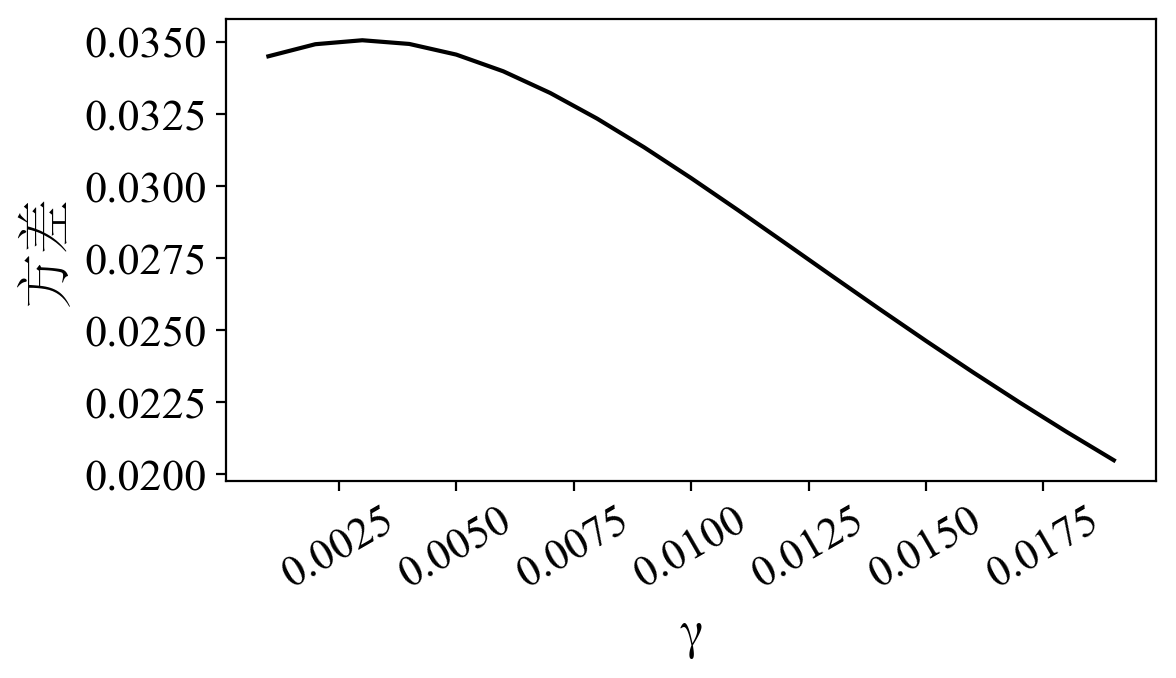

In [2]:
plt.figure(figsize=config.rectangle_shape, dpi=config.dpi)
plt.style.use('mpl20')
# 确定gamma
def draw_2d(gama):
    att_ = sorted(enumerate(rbf_attention(all_n_vec,all_vec,gama)[0]), key=lambda x: x[1], reverse=True)
    index_of_att=[each[0] for each in att_]
    return [att_[i][1] for i in range(len(index_of_att))]
RESULT=[]
le=[i for i in np.arange(0.001,0.02,0.001)]
for g in le:
    result=draw_2d(g)
    # 归一化
    result=[(each-np.min(result))/(np.max(result)-np.min(result)) for each in result]
    # 方差
    RESULT.append(np.var(np.array(result)))
print(RESULT)
gama=le[RESULT.index(max(RESULT))]
print(gama)

plt.plot(le,RESULT,color='black')
plt.xticks(fontsize=config.ticks_fontsize,fontfamily=config.english_fontfamily,rotation=config.rotation)
plt.yticks(fontsize=config.ticks_fontsize,fontfamily=config.english_fontfamily)
plt.xlabel('γ',fontsize=config.label_fontsize,fontfamily=config.chinese_fontfamily)
plt.ylabel('方差',fontsize=config.label_fontsize,fontfamily=config.chinese_fontfamily)

Text(0, 0.5, 'SCORE')

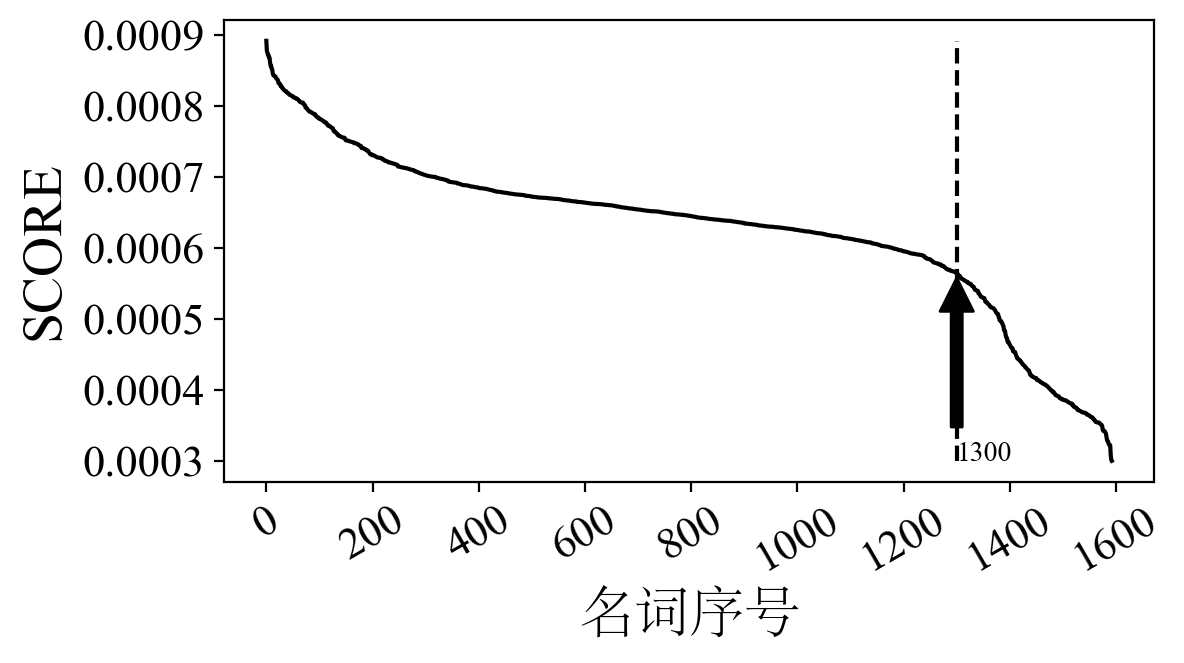

In [6]:

# # 注意力分数值
gama=0.003
plt.figure(figsize=config.rectangle_shape, dpi=config.dpi)
att_ = sorted(enumerate(rbf_attention(all_n_vec,all_vec,gama)[0]), key=lambda x: x[1], reverse=True)
index_of_att=[each[0] for each in att_]
plt.annotate('1300',xy=(1300,0.00057),xytext=(1300,0.0003),fontsize=config.annoate_fontsize,color='black',fontfamily=config.english_fontfamily,arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([att_[i][1] for i in range(len(index_of_att))],color='black')
plt.vlines(1300,min([att_[i][1] for i in range(len(index_of_att))]),max([att_[i][1] for i in range(len(index_of_att))]),linestyles='--',colors='black')

plt.xticks(fontsize=config.ticks_fontsize,fontfamily=config.english_fontfamily,rotation=config.rotation)
plt.yticks(fontsize=config.ticks_fontsize,fontfamily=config.english_fontfamily)
plt.xlabel('名词序号',fontsize=config.label_fontsize,fontfamily=config.chinese_fontfamily)
plt.ylabel('SCORE',fontsize=config.label_fontsize,fontfamily=config.english_fontfamily)

# 保存结果
# with open('所有词的注意力分数值.tsv','w',encoding='utf-8') as f:
#     for i in range(len(att_)):
#         f.write(all_n[index_of_att[i]]+'\t'+str(att_[i][1])+'\n')